In [1]:
import requests
from bs4 import BeautifulSoup

In [17]:
url = 'https://in.tradingview.com/chart/?symbol=ECONOMICS%3AININTR'

In [18]:
resp = requests.get(url)

In [19]:
with open('chart.html', 'wb') as f:
    f.write(resp.content)

In [20]:
url = 'wss://data.tradingview.com/socket.io/websocket?from=chart%2F&date=2024_08_16-11_20&type=chart'

In [6]:
from websocket import create_connection
import ssl

ws = create_connection('wss://data.tradingview.com/socket.io/websocket?&type=chart', sslopt={"cert_reqs": ssl.CERT_NONE})


# while connection is open print received value

result = ws.recv()
print(result)
ws.send('~m~54~m~{"m":"set_auth_token","p":["unauthorized_user_token"]}')


~m~288~m~{"session_id":"0.10405.1038_hkg1-charts-21-webchart-1","timestamp":1724085688,"timestampMs":1724085688581,"release":"release_207-84","studies_metadata_hash":"4e7b00cbf8bba508529f0424f6adaf009d471e6b","auth_scheme_vsn":2,"protocol":"json","via":"45.135.231.232:443","javastudies":["3.66"]}


68

In [5]:
from bs4 import BeautifulSoup
import json
import moment
import re
import asyncio
import pyppeteer
import nest_asyncio

nest_asyncio.apply()

pyppeteer.DEBUG = False
headless = True
# headless = False
args = [
    '--window-size=1024,768',
    '--no-sandbox',
    '--disable-setuid-sandbox',
    '--ignore-certificate-errors',
    '--disable-dev-shm-usage',
    '--single-process'
]

loop = asyncio.get_event_loop()


headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'
}


async def get_csv(url):
    browser = await pyppeteer.launch(headless=headless, ignoreHTTPSErrors=True, args=args, handleSIGINT=False,
                                     handleSIGTERM=False, handleSIGHUP=False)
    page = await browser.newPage()
    page.setDefaultNavigationTimeout(60000)
    await page.setViewport(dict(width=1024, height=768))
    await page.setUserAgent(headers['user-agent'])
    await page.goto(url)
    await page.waitForSelector('.pane-legend-title__container')
    content = await page.content()
    await page.close()
    await browser.close()
    return content

try:
    url = True
    if url:
        url = 'https://in.tradingview.com/chart/?symbol=ECONOMICS%3AININTR'
        content = loop.run_until_complete(get_csv(url))
        soup = BeautifulSoup(content, 'lxml')

        ind_titles = soup.findAll(attrs={"class": "pane-legend-line"})
        _ind_titles = []
        _ind_values = []
        for ind in ind_titles:
            name = ind.find(attrs={"class": "pane-legend-title__description"})
            values = ind.findAll(attrs={"class": "pane-legend-item-value-wrap"})
            _loc_values = []
            for val in values:
                _loc_values.append(val.get_text())
            _ind_values.append(' '.join(list(map(str, _loc_values))))
            _ind_titles.append(name.get_text())

        json_string = soup.find(attrs={"class": "js-chart-view"})['data-options']
        parsed_string = json.loads(json_string)
        parsed_string = json.loads(parsed_string['content'])['panes']

        main = None
        indicators = []

        for item in parsed_string:
            for item2 in item['sources']:
                if item2['type'] == 'MainSeries':
                    main = item2
                elif item2['type'] == 'Study':
                    indicators.append(item2)
        title = 'Untitled'
        r = '\nno data\n'
        if main:
            title = soup.find(attrs={"class": "pane-legend-title__container"}).get_text()
            d = main['bars']['data']
            columns = ['time', 'open', 'high', 'low', 'close', 'vol', '%', 'id', 'timestamp']

            if (len(indicators)):
                for i in indicators:
                    _name = i['metaInfo']['shortDescription']
                    for _n in range(len(i['data']['data'][0]['value'])):
                        _s = 1
                        for _i in i['data']['data']:
                            if _i['value'][_n] != 0 and _i['value'][_n] != 1:
                                _s = 0
                                break
                        if _s == 1:
                            for _i in i['data']['data']:
                                _i['value'].pop(_n)
                            break

                    for name in _ind_titles:
                        s = 1
                        if not re.match('^' + str(_name), name):
                            s = 0
                        if 'source' in i['state']['inputs'] and not re.search(str(i['state']['inputs']['source']),
                                                                                name):
                            s = 0
                        if 'length' in i['state']['inputs'] and not re.search(str(i['state']['inputs']['length']),
                                                                                name):
                            s = 0
                        if 'increment' in i['state']['inputs'] and not re.search(
                                str(i['state']['inputs']['increment']),
                                name):
                            s = 0
                        if 'max value' in i['state']['inputs'] and not re.search(
                                str(i['state']['inputs']['max value']),
                                name):
                            s = 0
                        if 'start' in i['state']['inputs'] and not re.search(
                                str(i['state']['inputs']['start']),
                                name):
                            s = 0
                        for n in range(12):
                            if 'in_' + str(n) in i['state']['inputs'] and not re.search(
                                    str(i['state']['inputs']['in_' + str(n)]),
                                    name):
                                s = 0

                        if s:
                            _name = name
                            break

                    count_columns = len(i['data']['data'][0]['value']) - 1

                    for number in range(count_columns):
                        columns.append('"' + _name + '"')

            # r = '"' + title + '"' + (',' * (len(columns) - 1)) + '\n'
            # r += ','.join(columns) + '\n'
            r = ','.join(columns) + '\n'

            i = 0
            close = None
            for item in d:
                item['value'] = item['value'][0:6]
                data_ind = []
                procent = None
                for item2 in indicators:
                    for item3 in item2['data']['data']:
                        if item['value'][0] == item3['value'][0]:
                            item3['value'] = list(map(str, item3['value']))
                            item3['value'].pop(0)
                            data_ind.append(','.join(item3['value']))
                            break
                if close:
                    procent = round((item['value'][-2] - close) / (close / 100), 2)
                close = item['value'][-2]
                r += ','.join(list(map(str, item['value']))) + ',' + str(procent) + ',' + str(
                    i) + ',' + moment.unix(
                    item['value'][0] * 1000, utc=True).format("YYYY-MM-DD HH:mm:ss") + ',' + ','.join(
                    data_ind) + '\n'
                i += 1
        title = re.sub(r'[^\w\d&]+', '_', title.strip()).strip()
        print(title)
        # return Response(r, mimetype="text/csv",
        #                 headers={"Content-disposition": "attachment; filename=" + title + ".csv"})
    print( '{"error":"no url parameter"}')
except Exception as e:
    print('{"error":"' + str(e) + '"}')

[W:pyppeteer.chromium_downloader] Starting Chromium download. Download may take a few minutes.
100%|██████████| 137M/137M [10:12<00:00, 224kb/s]  
[W:pyppeteer.chromium_downloader] Chromium download done.
[W:pyppeteer.chromium_downloader] chromium extracted to: C:\Users\Ishant\AppData\Local\pyppeteer\pyppeteer\local-chromium\588429


{"error":"Browser closed unexpectedly:
"}


In [7]:
from price_loaders.tradingview import load_asset_price

In [14]:
import pytz

In [ ]:
pytz.timezone('Asia/Kolkata')

In [41]:
india_gdp_per_capita = 'INGDPPC'

In [73]:
import websocket
from websocket import create_connection

import json
import random
import string
import re


import logging
from typing import List, Iterator, Literal
import requests

import pandas as pd
import numpy as np
from typing import Optional
import datetime
import pytz


AvailableTimeFrame = Literal[
    "1",
    "3",
    "5",
    "15",
    "45",
    "1h",
    "2h",
    "3h",
    "4h",
    "1D",
    "1W",
    "1M",
    "3M",
    "6M",
    "12M",
]


class SESSION_ENUM:
    """
    Description:
        Session constants
    """

    WEBSOCKET: bool = False
    CHART: bool = True


headers = json.dumps(
    {
        "Origin": "https://data.tradingview.com",
    }
)


def generate_sesssion(session) -> str:
    """
    Description:
        Get {session prefix}_{random string}
    Args:
        session (bool)
            True: for websocket
            False: for chart
    Returns:
        (str) web socket session
    """
    string_length = 12
    letters = string.ascii_lowercase
    random_string = "".join(
        random.choice(letters) for i in range(string_length)
    )
    prefix = "cs" if session else "qs"
    return f"{prefix}_{random_string}"


def prepend_header(sentences: str) -> str:
    """
    Description:
        format data into websocket message:
    Args:
        sentence
            (str) contructed message
    Returns:
        (str) An added prefix message
    Example:
        ~m~54~m~{"m":"set_auth_token","p":["unauthorized_user_token"]}
    """
    return f"~m~{len(sentences)}~m~{sentences}"


def construct_message(function_name: str, parameters: List[str]) -> str:
    """
    Args:
        function_name
            (str) Function to summit into websocket
        parameters:
            List[str]: list paramaters to input into the function
    Returns:
        (str) a message as a JSON format join without space
    Example:
        {"m":"set_auth_token","p":["unauthorized_user_token"]}
    """
    transformed_params = []
    for parameter in parameters:
        if isinstance(parameter, str):
            transformed_params.append(parameter)
        elif isinstance(parameter, dict):
            transformed_params.append(json.dumps(parameter).replace("/", ""))
        else:
            transformed_params.append(parameter)
    return json.dumps(
        {"m": function_name, "p": transformed_params}, separators=(",", ":")
    )  # .replace('"(', '{').replace('}"', '}')


def create_message(function_name: str, parameters: List[str]) -> str:
    """
    Description:
        Integration of a created message function
    Args:
        function_name:
            (str) Function to summit into websocket
        parameters:
            List[str]: list paramaters to input into the function
    Returns:
        (str) message as websocket message format
    Example:
        ~m~54~m~{"m":"set_auth_token","p":["unauthorized_user_token"]}
    """
    output = prepend_header(construct_message(function_name, parameters))
    return output


def send_message(
    ws: websocket._core.WebSocket, func: str, args: List[str]
) -> None:
    """
    Description:
        Send formatted message
    Params:
        ws:
            (websocket._core.WebSocket) web socket sesssoin
        func:
            (str) Function to summit into websocket
        args:
            List[str]: list paramaters to input into the function
    """

    ws.send(create_message(func, args))


def get_pe_ratio_template():
    headers = {
        "authority": "pine-facade.tradingview.com",
        "accept": "application/json, text/javascript, */*; q=0.01",
        "accept-language": "en-GB,en;q=0.9",
        # 'if-none-match': 'W/"rscUUmqLJOxhFguZvk588Rqfz37Es9R6f9UjLoBPJrgOHvnMmnx3/MwXZrOCaitLpw8ogsgzOhaGQ4ALxt7xnA=="', # noqa
        "origin": "https://www.tradingview.com",
        "referer": "https://www.tradingview.com/",
        "sec-ch-ua": '" Not A;Brand";v="99", "Chromium";v="101", "Google Chrome";v="101"',  # noqa
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Windows"',
        "sec-fetch-dest": "empty",
        "sec-fetch-mode": "cors",
        "sec-fetch-site": "same-site",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36",  # noqa
    }

    response = requests.get(
        "https://pine-facade.tradingview.com/pine-facade/translate/STD%3BFund_price_earnings/38.0/",  # noqa
        headers=headers,
    )
    return response.json()["result"]["ilTemplate"]


def get_pe_ratio_message(
    chart_session, chart_session_name, study_name="pe_ratio"
):
    text = get_pe_ratio_template()
    parameters = json.dumps(
        {
            "text": text,
            "pineId": "STD;Fund_price_earnings",
            "pineVersion": "38.0",
            "in_0": {"v": "", "f": True, "t": "symbol"},
            "__user_pro_plan": {"v": "", "f": True, "t": "usertype"},
        }
    )

    message = (
        '{"m":"create_study","p":["'
        + chart_session
        + f'","{study_name}","st1","{chart_session_name}","Internal@tv-scripting-101!",'  # noqa
        + parameters
        + "]}"
    )

    message = f"~m~{len(message)}~m~{message}"
    return message


def request_data(
    symbol: str,
    time_frame: str,
    look_back_bars: int,
    websocket_session,
    chart_session,
):
    # look_back_bars = 365 * 10

    resolve_symbol = json.dumps({"symbol": symbol, "adjustment": "splits"})

    # Set up session
    chart_session_name = "price"
    ws = create_connection(
        "wss://data.tradingview.com/socket.io/websocket", headers=headers
    )

    send_message(ws, "set_auth_token", ["unauthorized_user_token"])
    send_message(ws, "chart_create_session", [chart_session, ""])
    send_message(ws, "quote_create_session", [websocket_session])

    send_message(
        ws,
        "quote_add_symbols",
        [websocket_session, symbol, {"flags": ["force_permission"]}],
    )

    send_message(
        ws, "resolve_symbol", [chart_session, "symbol_1", f"={resolve_symbol}"]
    )
    logging.debug(f"Time frame {time_frame}")
    send_message(
        ws,
        "create_series",
        [
            chart_session,
            chart_session_name,
            chart_session_name,
            "symbol_1",
            time_frame,
            look_back_bars,
        ],
    )
    return ws


def listen(
    symbol: str, look_back_bars: int, time_frame: AvailableTimeFrame
) -> Iterator[dict]:
    """
    Open a websocket channel and wait for return.


    Args:
        symbol (str): Target symbol
        look_back_bars (int): Number of bar to look back
        time_frame (str)

    Yields:
        Iterator[dict]: Yield dictionary until it found stop
            the stop condition.
    """
    websocket_session = generate_sesssion(SESSION_ENUM.WEBSOCKET)
    logging.debug(f"Web socket session generated: {websocket_session}")

    chart_session = generate_sesssion(SESSION_ENUM.CHART)
    chart_session_name = "price"
    # chart_session = "cs_j11Xz8aCaxfT"
    logging.debug(f"Chart session generated: {chart_session}")

    ws = request_data(
        symbol, time_frame, look_back_bars, websocket_session, chart_session
    )
    ws.send(get_pe_ratio_message(chart_session, chart_session_name))
    while True:
        try:
            results: str = ws.recv()
            logging.debug(results)
            pattern = re.compile("~m~\d+~m~~h~\d+$")  # noqa

            if pattern.match(results):
                # Send heart beat to keep connection alive
                ws.recv()
                ws.send(results)

            for r in results.split("~m~"):
                try:
                    r = json.loads(r)
                    if not isinstance(r, dict):
                        continue
                    message = r.get("m")
                    if (
                        message == "timescale_update"
                        or message == "du"
                        or message == "study_error"
                    ):
                        yield r
                        # return r
                except json.JSONDecodeError:
                    pass
        except KeyboardInterrupt:
            logging.debug("End")
            break


def load_raw_data(
    symbol: str, look_back_bars: int, time_frame: AvailableTimeFrame
) -> dict:
    """Load price as raw data.

    Args:
        symbol (str): Target symbol
        look_back_bars (int): Number of look bars
        time_frame (AvailableTimeFrame): Observing timeframe

    Returns:
        dict: Raw chart data
    """
    chart = {}

    for res in listen(symbol, look_back_bars, time_frame):
        m = res["m"]
        if m == "study_error":
            break
        p = res["p"]
        data = [element for element in p if isinstance(element, dict)][0]
        if not (("price" in chart) and ("price" in data)):
            chart = {**chart, **data}
        if "pe_ratio" in chart:
            break
    return chart


def extract_price(chart: dict) -> pd.DataFrame:
    """Extract ohlcv chart.

    Args:
        chart (dict): Raw chart data.

    Returns:
        pd.DataFrame: Result dataframe
    """
    return pd.DataFrame(
        [st["v"] for st in chart["price"]["s"]],
    ).rename(
        columns={
            0: "time",
            1: "open",
            2: "high",
            3: "low",
            4: "close",
            5: "volume",
        }
    )


def extract_pe_ratio(chart: dict) -> Optional[pd.DataFrame]:
    """Extracting PE ratio from RAW chart

    Args:
        chart (dict): raw chart data

    Returns:
        Optional[pd.DataFrame]:
         - None if pe_ratio not found in the chart data
         - Dataframe if from
    """
    if "pe_ratio" not in chart:
        return None
    df = pd.DataFrame(
        [st["v"] for st in chart["pe_ratio"]["st"]],
        columns=["time", "pe_ratio"],
    )
    df["pe_ratio"] = df["pe_ratio"].astype(np.float64)
    return df


def aggregate_to_dataframe(
    chart: dict, timezone: Optional[pytz.timezone] = None
) -> pd.DataFrame:
    """Aggregate raw chart data in a Pandas dataframe.

    Args:
        chart (dict): Raw chart data
        timezone (Optional[pytz.timezone], optional):
            Operating timezone. Defaults to None.

    Returns:
        pd.DataFrame: Return as a dataframe
    """
    if timezone is None:
        timezone = pytz.timezone("Asia/Bangkok")
    ohlcv = extract_price(chart)
    logging.debug(ohlcv)
    pe_ratio = extract_pe_ratio(chart)
    if pe_ratio is not None:
        ohlcv = pd.concat(
            [ohlcv.set_index("time"), pe_ratio.set_index("time")], axis=1
        ).reset_index()

    # print(ohlcv) Sihag
    def convert_timestamp(timestamp, timezone):
        try:
            # For negative timestamps, handle manually
            if timestamp < 0:
                base_datetime = datetime.datetime(1970, 1, 1, tzinfo=datetime.timezone.utc)
                dt_utc = base_datetime + datetime.timedelta(seconds=timestamp)
            else:
                # Convert timestamp to naive datetime in UTC for positive timestamps
                dt_utc = datetime.datetime.utcfromtimestamp(timestamp)
                dt_utc = dt_utc.replace(tzinfo=datetime.timezone.utc)
            
            # Convert to the desired timezone
            dt_localized = dt_utc.astimezone(timezone)
            return dt_localized
        except (OSError, ValueError) as e:
            print(f"Error converting timestamp {timestamp}: {e}")
            return None  # Or handle the error as needed

    # Apply the conversion function to the 'time' column
    ohlcv['time'] = ohlcv['time'].apply(lambda timestamp: convert_timestamp(timestamp, timezone))

    # ohlcv.time = ohlcv.time.apply(
    #     lambda timestamp: datetime.datetime.fromtimestamp(
    #         timestamp, tz=timezone
    #     )
    # ) Sihag
    
    ohlcv = ohlcv.dropna(subset=["open", "high", "low", "close"])
    ohlcv[["open", "high", "low", "close"]] = ohlcv[
        ["open", "high", "low", "close"]
    ].astype(np.float64)
    return ohlcv


def load_asset_price(
    symbol: str,
    look_back_bars: int,
    time_frame: AvailableTimeFrame,
    timezone: Optional[pytz.timezone] = None,
) -> pd.DataFrame:
    """Run full process to scrape TradingView data

    Args:
        symbol (str): Asset symbol
        look_back_bars (int): Number of look back bars
        time_frame (AvailableTimeFrame): Time frame
        timezone (Optional[pytz.timezone], optional): Timezone.
            Defaults to None.

    Returns:
        pd.DataFrame: return as a dataframe
    """
    chart = load_raw_data(symbol, look_back_bars, time_frame)
    return aggregate_to_dataframe(chart, timezone)


In [74]:
df = load_asset_price(india_gdp_per_capita, 55,'1M')

In [76]:
df = load_asset_price(india_gdp_per_capita, 1200,'1M', pytz.timezone('Asia/Kolkata'))

In [77]:
df

,time,open,high,low,close
0,1960-12-01 05:30:00+05:30,305.79,305.79,305.79,305.79
1,1961-12-01 05:30:00+05:30,309.95,309.95,309.95,309.95
2,1962-12-01 05:30:00+05:30,311.74,311.74,311.74,311.74
3,1963-12-01 05:30:00+05:30,322.89,322.89,322.89,322.89
4,1964-12-01 05:30:00+05:30,339.06,339.06,339.06,339.06
...,...,...,...,...,...
59,2019-12-01 05:30:00+05:30,1944.31,1944.31,1944.31,1944.31
60,2020-12-01 05:30:00+05:30,1813.53,1813.53,1813.53,1813.53
61,2021-12-01 05:30:00+05:30,1961.96,1961.96,1961.96,1961.96
62,2022-12-01 05:30:00+05:30,2098.22,2098.22,2098.22,2098.22


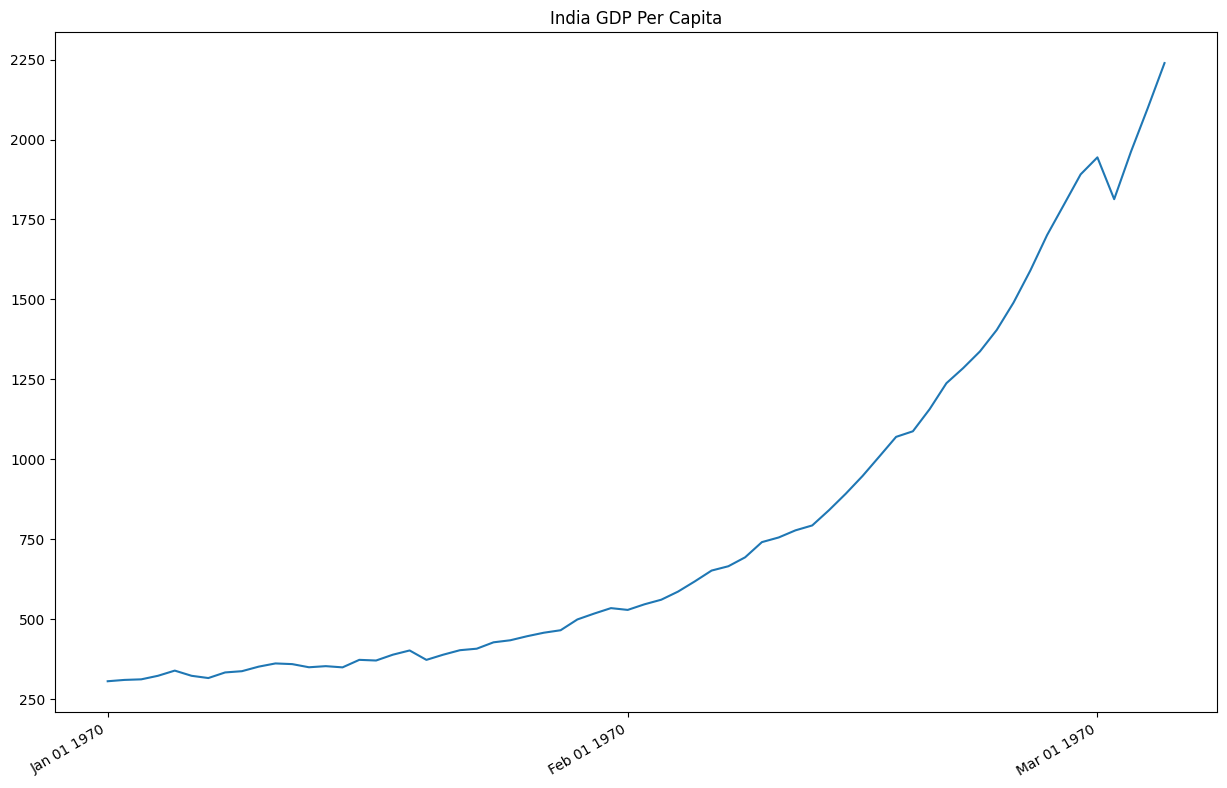

In [82]:
# plot the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15, 10))
plt.title('India GDP Per Capita')


ax.plot(df.index, df['close'], label='Close Price')

# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator())
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))

# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()
